In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Human melanoma sample
# https://singlecell.broadinstitute.org/single_cell/study/SCP2171/slide-tags-snrna-seq-on-human-melanoma

datadir = '../../data/melanoma'
X = pd.read_csv(f'{datadir}/HumanMelanomaRNA_expression.csv.gz', index_col=0) # this seems to be normalized already
X = X.T.astype(float)

metadata = pd.read_csv(f'{datadir}/HumanMelanomaRNA_metadata.csv', index_col=0)
metadata = metadata.drop('TYPE', axis=0)

spatial = pd.read_csv(f'{datadir}/HumanMelanomaRNA_spatial.csv', index_col=0)
spatial = spatial.drop('TYPE', axis=0)

adata = sc.AnnData(X)
adata.obs = metadata
adata.obsm['spatial'] = spatial[['X', 'Y']].values
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)

adata

AnnData object with n_obs × n_vars = 4804 × 25066
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cluster'
    obsm: 'spatial'

In [4]:
adata.X.min(), adata.X.max()

(0.0, 8.13270210502644)

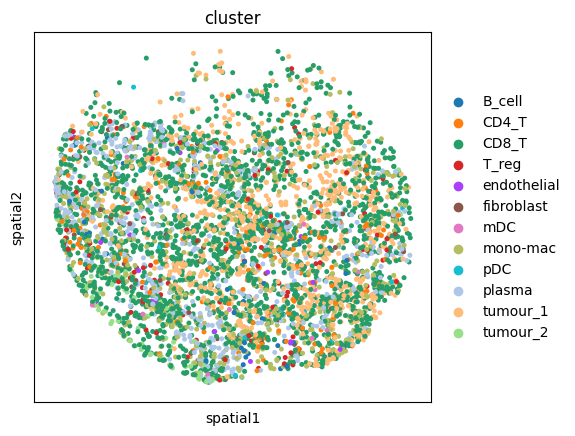

In [5]:
sc.pl.spatial(adata, color='cluster', spot_size=40)

In [6]:
n_top_genes = 3000
min_cells = 10
min_counts = 250

In [7]:
immune_genes = [] # Don't force inclusion of immune genes

adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
adata = adata[:, ~adata.var["mt"]]

sc.pp.filter_genes(adata, min_cells=min_cells)
# adata.layers["raw_count"] = adata.X.copy()
# sc.pp.normalize_total(adata, inplace=True)
# sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes) 

adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(immune_genes))]
adata.layers["normalized_count"] = adata.to_df().values
adata

/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/tmp/ipykernel_49121/3091500594.py:21: ImplicitModificationWarning: Setting element `.layers['normalized_count']` of view, initializing view as actual.
  adata.layers["normalized_count"] = adata.to_df().values


AnnData object with n_obs × n_vars = 4804 × 3000
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'hvg'
    obsm: 'spatial'
    layers: 'normalized_count'

In [8]:
adata.obs['cluster'].value_counts()

CD8_T          2119
tumour_1        812
mono-mac        692
plasma          602
CD4_T           198
T_reg           123
tumour_2         87
B_cell           52
fibroblast       50
pDC              26
mDC              25
endothelial      18
Name: cluster, dtype: int64

In [9]:
# Create column that contains integer labels for cluster
adata.obs['cluster_cat'] = pd.Categorical(adata.obs['cluster']).codes
adata.obs['cluster_cat'].value_counts()

2     2119
10     812
7      692
9      602
1      198
3      123
11      87
0       52
5       50
8       26
6       25
4       18
Name: cluster_cat, dtype: int64

In [10]:
cluster_mapping = dict(adata.obs[['cluster_cat', 'cluster']].drop_duplicates().values)
cluster_mapping = {str(k): v for k, v in cluster_mapping.items()}
cluster_mapping

{'2': 'CD8_T',
 '10': 'tumour_1',
 '3': 'T_reg',
 '1': 'CD4_T',
 '7': 'mono-mac',
 '9': 'plasma',
 '8': 'pDC',
 '6': 'mDC',
 '5': 'fibroblast',
 '11': 'tumour_2',
 '0': 'B_cell',
 '4': 'endothelial'}

In [11]:
adata.write_h5ad(f'/ix/djishnu/shared/djishnu_kor11/training_data/HumanMelanomaRNA.h5ad')